# PCA on the Glass Identification Dataset

This notebook implements **Principal Component Analysis (PCA)** from scratch on the UCI Glass Identification dataset and visualizes the result in 2D.

**Design choices**
- Standardize features via **z-score** (mean 0, std 1; `ddof=0`).
- Compute PCA via the **feature covariance** matrix using the **population** convention(N):  
  (eigenvalues are per-PC **population variances**).
- Also show PCA via **SVD** and verify the equivalence/decompositions:  
- Visualize **PC1 vs PC2** colored by `Class`.

**What you will verify**
- `trace(Σ)` equals the **sum of eigenvalues** (total variance).  
- **Explained variance ratio** (EVR) and **cumulative EVR** from eigenvalues/SVD match.  
- **Reconstruction error (MSE)** with population scaling:


## Contents
1. Load data  
2. Z-score standardization  
3. PCA via covariance + eigen  
4. PCA via SVD (equivalence check)  
5. Equivalence Check: trace(Cov) == sum(eigenvalues)
6. PC1 vs PC2 scatter (colored by Class)  
7. Mean Square Error 


In [ ]:
# 1) Load data 
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("glass+identification/glass.data") 

column_names = ["Id","RI","Na","Mg","Al","Si","K","Ca","Ba","Fe","Class"]

if not DATA_PATH.exists():
    # If file is missing, explain how to get it (avoid hard-coded downloads here).
    raise FileNotFoundError(
        f"{DATA_PATH} not found.\n"
        "Please place the Glass CSV at data/glass.csv with columns:\n"
        "Id, RI, Na, Mg, Al, Si, K, Ca, Ba, Fe, Class"
    )

df = pd.read_csv(DATA_PATH, names=column_names)

# Keep numeric features only (exclude Id and Class)
feature_cols = ["RI","Na","Mg","Al","Si","K","Ca","Ba","Fe"]
X = df[feature_cols].to_numpy().astype(float)
y = df["Class"]
print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (214, 9) | y shape: (214,)


In [ ]:
# 2) Z-score standardization (ddof=0 because we handle population where we are considering N)
mu = X.mean(axis=0, keepdims=True)
sigma = X.std(axis=0, ddof=0, keepdims=True)
Xs = (X - mu) / sigma

Xs[:3], mu.ravel(), sigma.ravel()


(array([[ 0.87286765,  0.28495326,  1.25463857, -0.69244192, -1.12708201,
         -0.67170546, -0.14576634, -0.35287683, -0.5864509 ],
        [-0.24933347,  0.59181718,  0.63616803, -0.17046023,  0.10231907,
         -0.02621325, -0.79373376, -0.35287683, -0.5864509 ],
        [-0.72131806,  0.14993314,  0.60142249,  0.19091171,  0.43878673,
         -0.16453301, -0.82894938, -0.35287683, -0.5864509 ]]),
 array([1.51836542e+00, 1.34078505e+01, 2.68453271e+00, 1.44490654e+00,
        7.26509346e+01, 4.97056075e-01, 8.95696262e+00, 1.75046729e-01,
        5.70093458e-02]),
 array([0.00302976, 0.81469337, 1.43903379, 0.49810176, 0.77273399,
        0.65066625, 1.41982447, 0.49605617, 0.09721077]))

In [ ]:
# 3) PCA via covariance + eigen-decomposition (covariance: ddof=0 => divide by n)
n = Xs.shape[0]
# Sample covariance (rowvar=False): Xs.T @ Xs / (n-1)
Cov = (Xs.T @ Xs) / n

# eigh for symmetric matrices; returns eigenvalues (ascending), eigenvectors (columns)
eigvals, eigvecs = np.linalg.eigh(Cov)

# sort descending by eigenvalue
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

explained_var_ratio = eigvals / eigvals.sum()

# Project standardized data (new coordinates in projected space)
Z_eig = Xs @ eigvecs

print("Eigen values:", eigvals)
print("Explained variance ratio (first 5):", np.round(explained_var_ratio[:5], 6))
print("Cumulative (first 5):", np.round(np.cumsum(explained_var_ratio)[:5], 6))
Z_eig[:3]


Eigen values: [2.51116373e+00 2.05007218e+00 1.40484399e+00 1.15786245e+00
 9.14002247e-01 5.27635193e-01 3.68958443e-01 6.38529478e-02
 1.60881782e-03]
Explained variance ratio (first 5): [0.279018 0.227786 0.156094 0.128651 0.101556]
Cumulative (first 5): [0.279018 0.506804 0.662898 0.791549 0.893105]


array([[-1.15113957, -0.52948764, -0.37209565, -1.72890103,  0.25193583,
        -0.34021008, -0.39560005, -0.19716008,  0.01634649],
       [ 0.57413717, -0.75978777, -0.55670817, -0.76023228,  0.25707069,
         0.11596015, -0.02415793, -0.28421356, -0.0107898 ],
       [ 0.94015972, -0.92983597, -0.55490744, -0.20625431,  0.23750587,
        -0.12663032, -0.36751757, -0.09594067,  0.02164019]])

In [ ]:
# 4) PCA via SVD (equivalence): Xs = U S V^T
U, S, Vt = np.linalg.svd(Xs, full_matrices=False)
# Variance per component: S^2/n
svd_eigvals = (S**2) / n
svd_components = Vt.T  # columns correspond to principal axes

# Align directions (signs) may differ; check first component correlation
Z_svd = Xs @ svd_components
corr_pc1 = np.corrcoef(Z_eig[:,0], Z_svd[:,0])[0,1]
print(f"corr(PC1_eig, PC1_svd) ≈ {corr_pc1:.6f}")

svd_ev_ratio = svd_eigvals / svd_eigvals.sum()
np.allclose(explained_var_ratio, svd_ev_ratio, atol=1e-10)


corr(PC1_eig, PC1_svd) ≈ 1.000000


True

In [30]:
# 5) Equivalence Check: trace(Cov) == sum(eigenvalues)
trace_cov = float(np.trace(Cov))
sum_eigvals  = float(eigvals.sum())

print(f"trace(Cov)={trace_cov:.2f}, sum(sum_eigvals)={sum_eigvals:.2f}")

np.testing.assert_allclose(trace_cov, sum_eigvals, rtol=1e-10, atol=1e-12)

trace(Cov)=9.00, sum(sum_eigvals)=9.00


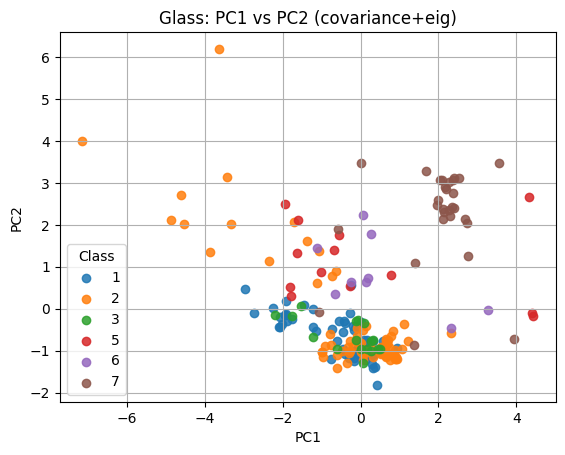

In [31]:
# 6) PC1 vs PC2 scatter colored by Class
import matplotlib.pyplot as plt

pc1, pc2 = Z_eig[:,0], Z_eig[:,1]

plt.figure()
for cls in sorted(np.unique(y)):
    mask = (y == cls)
    plt.scatter(pc1[mask], pc2[mask], label=str(cls), alpha=0.85)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Glass: PC1 vs PC2 (covariance+eig)")
plt.legend(title="Class")
plt.grid(True)
plt.show()


In [ ]:
# 7) Mean Square Error 
n, d = Xs.shape

# Variance captured by 2 PCs
var_kept_2 = eigvals[:2].sum()

total_var  = eigvals.sum()

mse_per_sample  = total_var - var_kept_2          # SSE / n
mse_per_element = mse_per_sample / d              # average per feature as well

print("Info captured by 2 PCs:", var_kept_2)
print("MSE per sample        :", mse_per_sample)
print("MSE per element       :", mse_per_element)


Info captured by 2 PCs: 4.5612359110014165
MSE per sample        : 4.438764088998582
MSE per element       : 0.4931960098887313
